In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import joblib


In [51]:
data = fetch_openml('credit-g', version=1, as_frame=True)
df = data.frame.copy()
df.dropna(inplace=True)


In [52]:
df['credit_per_month'] = df['credit_amount'] / (df['duration'] + 1)


In [53]:
X = df.drop('class', axis=1)
y = (df['class'] == 'good').astype(int)  # Convert 'good' to 1, 'bad' to 0


In [54]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [56]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])


In [57]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])


In [58]:
model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'credit_amount',
                                                   'installment_commitment',
                                                   'residence_since', 'age',
                                                   'existing_credits',
                                                   'num_dependents',
                                                   'credit_per_month']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [59]:
joblib.dump(model_pipeline, 'credit_model.pkl')
print("✅ Model saved as credit_model.pkl")


✅ Model saved as credit_model.pkl


In [60]:
y_pred = model_pipeline.predict(X_test)
y_prob = model_pipeline.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"🎯 ROC-AUC Score: {roc_auc:.4f}")



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.23      0.30        60
           1       0.73      0.87      0.79       140

    accuracy                           0.68       200
   macro avg       0.58      0.55      0.55       200
weighted avg       0.64      0.68      0.65       200

🎯 ROC-AUC Score: 0.6071


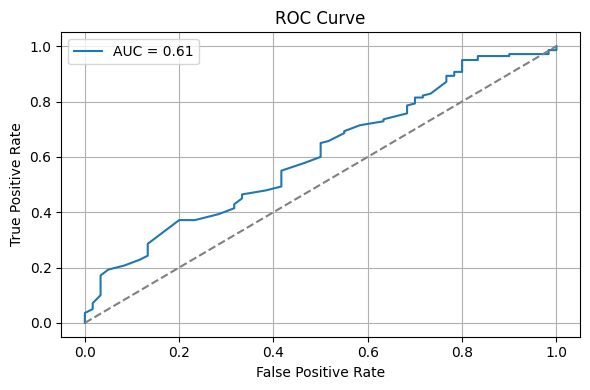

In [61]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
